In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [2]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas as pd
import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

2023-09-30 20:15:49.613073: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-30 20:15:49.613125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-30 20:15:49.613159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-30 20:15:50.540156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minve

In [3]:
od.download("https://www.kaggle.com/datasets/gonzajl/tumores-cerebrales-mri-dataset")

Skipping, found downloaded files in "./tumores-cerebrales-mri-dataset" (use force=True to force download)


In [4]:
datos = pd.read_csv('tumores-cerebrales-mri-dataset/datos.csv')

In [5]:
datos

,imagen,glioma,meningioma,pituitary,no_tumor
0,./tumores-cerebrales-mri-dataset/glioma/G_1.jpg,1,0,0,0
1,./tumores-cerebrales-mri-dataset/glioma/G_10.jpg,1,0,0,0
2,./tumores-cerebrales-mri-dataset/glioma/G_100.jpg,1,0,0,0
3,./tumores-cerebrales-mri-dataset/glioma/G_100_...,1,0,0,0
4,./tumores-cerebrales-mri-dataset/glioma/G_100_...,1,0,0,0
...,...,...,...,...,...
43995,./tumores-cerebrales-mri-dataset/pituitary/ima...,0,0,1,0
43996,./tumores-cerebrales-mri-dataset/pituitary/ima...,0,0,1,0
43997,./tumores-cerebrales-mri-dataset/pituitary/ima...,0,0,1,0
43998,./tumores-cerebrales-mri-dataset/pituitary/ima...,0,0,1,0


In [6]:
cant_max = 1000

glioma_df = datos[datos['glioma'] == 1].head(cant_max)
meningioma_df = datos[datos['meningioma'] == 1].head(cant_max)
pituitary_df = datos[datos['pituitary'] == 1].head(cant_max)
no_tumor_df = datos[datos['no_tumor'] == 1].head(cant_max)

datos = pd.concat([glioma_df, meningioma_df, pituitary_df, no_tumor_df], ignore_index=True)

In [7]:
#mezcla la información en el dataset
datos = datos.sample(frac=1).reset_index(drop=True)

In [8]:
datos

,imagen,glioma,meningioma,pituitary,no_tumor
0,./tumores-cerebrales-mri-dataset/no-tumor/N_16...,0,0,0,1
1,./tumores-cerebrales-mri-dataset/meningioma/M_...,0,1,0,0
2,./tumores-cerebrales-mri-dataset/meningioma/M_...,0,1,0,0
3,./tumores-cerebrales-mri-dataset/pituitary/P_2...,0,0,1,0
4,./tumores-cerebrales-mri-dataset/no-tumor/N_17...,0,0,0,1
...,...,...,...,...,...
3995,./tumores-cerebrales-mri-dataset/no-tumor/N_14...,0,0,0,1
3996,./tumores-cerebrales-mri-dataset/no-tumor/N_19...,0,0,0,1
3997,./tumores-cerebrales-mri-dataset/pituitary/P_1...,0,0,1,0
3998,./tumores-cerebrales-mri-dataset/no-tumor/N_19...,0,0,0,1


In [9]:
def cargar_imagenes(nombres, et):
    imagenes = []
    etiquetas = []
    for i in range(len(nombres)):
        ruta = 'tumores-cerebrales-mri-dataset/' + nombres[i][2:]
        imagen = cv2.imread(ruta, cv2.IMREAD_COLOR)
        imagenes.append(imagen)
        etiquetas.append(list(et.iloc[i]))
    return imagenes, etiquetas

In [10]:
paths = datos.iloc[:, 0]
tags = datos.iloc[:, 1:]   #ignoro filas particulares y traigo las columnas de 1 a fin

In [11]:
imagenes, etiquetas = cargar_imagenes(paths, tags)

In [12]:
div_test = int(len(imagenes) * 0.8)

In [13]:
imagenes_entrenamiento, imagenes_prueba = imagenes[:div_test], imagenes[div_test:]
etiquetas_entrenamiento, etiquetas_prueba = etiquetas[:div_test], etiquetas[div_test:]

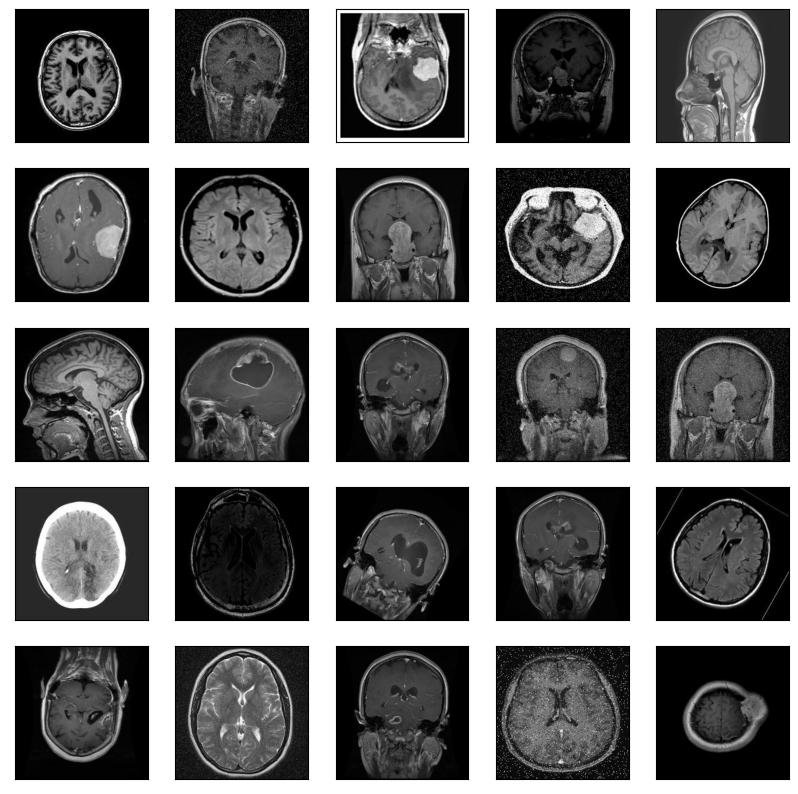

In [14]:
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagenes_entrenamiento[i])

plt.show()

In [15]:
# Normalización de entradas y conversión de listas a tensores
# no se banca hacerlo todo junto antes de dividir, por eso se hace separado
imagenes_entrenamiento = np.array(imagenes_entrenamiento).astype(float) / 255
imagenes_prueba = np.array(imagenes_prueba).astype(float) / 255

etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)
etiquetas_prueba = np.array(etiquetas_prueba)

In [17]:
vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

vgg16.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = vgg16(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [19]:
historial = model.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=20, validation_data=(imagenes_prueba, etiquetas_prueba))


Epoch 1/20
100/100 [==============================] - 297s 3s/step - loss: 1.3319 - categorical_accuracy: 0.4469 - val_loss: 1.2102 - val_categorical_accuracy: 0.5750
Epoch 2/20
100/100 [==============================] - 293s 3s/step - loss: 1.1207 - categorical_accuracy: 0.6547 - val_loss: 1.0460 - val_categorical_accuracy: 0.6875
Epoch 3/20
100/100 [==============================] - 294s 3s/step - loss: 0.9906 - categorical_accuracy: 0.6969 - val_loss: 0.9469 - val_categorical_accuracy: 0.7188
Epoch 4/20
100/100 [==============================] - 295s 3s/step - loss: 0.8993 - categorical_accuracy: 0.7272 - val_loss: 0.8820 - val_categorical_accuracy: 0.7125
Epoch 5/20
100/100 [==============================] - 295s 3s/step - loss: 0.8356 - categorical_accuracy: 0.7397 - val_loss: 0.8236 - val_categorical_accuracy: 0.7462
Epoch 6/20
100/100 [==============================] - 294s 3s/step - loss: 0.7833 - categorical_accuracy: 0.7556 - val_loss: 0.7829 - val_categorical_accuracy: 0.772

In [20]:
def es_correcta(prediccion, esperado):
    return prediccion.index(max(prediccion)) == esperado.index(max(esperado))

In [25]:
correctas_segun_tipo = [0, 0, 0, 0]
falladas_segun_tipo = [0, 0, 0, 0]

predicciones = model.predict(imagenes_prueba)
print(f"Cantidad de predicciones: {len(predicciones)}")

for i in range(len(predicciones)):
    prediccion = list(predicciones[i])
    index = prediccion.index(max(prediccion))
    
    if es_correcta(prediccion, list(etiquetas_prueba[i])):
        correctas_segun_tipo[index] += 1  
    else: 
        falladas_segun_tipo[index] += 1
        
cant_totales = list(map(lambda x, y: x + y, correctas_segun_tipo, falladas_segun_tipo))
print("Etiquetas:   [G,  M,  P,  N]")
print(f"Total:       {cant_totales}")
print(f"Correctas:   {correctas_segun_tipo}")
print(f"Incorrectas: {falladas_segun_tipo}")

25/25 [==============================] - 58s 2s/step
Cantidad de predicciones: 800
Etiquetas:   [G,  M,  P,  N]
Total:       [192, 201, 208, 199]
Correctas:   [168, 154, 176, 166]
Incorrectas: [24, 47, 32, 33]
